In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os
from imageio import imsave
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda:0


In [3]:
class Generator(nn.Module):
    def __init__(self, d=64):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.ConvTranspose2d(32, d * 8, 4, 2, 0),
            nn.BatchNorm2d(d * 8),
            nn.ELU(),
            nn.ConvTranspose2d(d * 8, d * 4, 4, 2, 0),
            nn.BatchNorm2d(d * 4),
            nn.ELU(),
            nn.ConvTranspose2d(d * 4, d * 2, 4, 2, 0),
            nn.BatchNorm2d(d * 2),
            nn.ELU(),
            nn.ConvTranspose2d(d * 2, d, 4, 1, 0),
            nn.BatchNorm2d(d),
            nn.ELU(),
            nn.ConvTranspose2d(d, 1, 4, 1, 0),
            nn.Tanh()
        )

    def forward(self, input):
        return self.network(input)

In [4]:
class Discriminator(nn.Module):
    def __init__(self, d=64):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, d, 4, 1, 1),
            nn.BatchNorm2d(d),
            nn.ELU(),
            nn.Conv2d(d, d * 2, 4, 1, 1),
            nn.BatchNorm2d(d * 2),
            nn.ELU(),
            nn.Conv2d(d * 2, d * 4, 4, 2, 1),
            nn.BatchNorm2d(d * 4),
            nn.ELU(),
            nn.Conv2d(d * 4, d * 8, 4, 2, 1),
            nn.BatchNorm2d(d * 8),
            nn.ELU(),
        )

        self.dense = nn.Sequential(
            nn.Linear(d * 8 * 6 * 6, 512),
            nn.ELU(),
            nn.Linear(512, 64),
            nn.ELU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        self.d = d

    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 8*self.d*6*6)
        x = self.dense(x)
        return x

In [5]:
g = Generator()
g.to(device)
d = Discriminator()
d.to(device)

/data/tbe17/python3/lib/python3.5/site-packages/torch/cuda/__init__.py:116: UserWarning: 
    Found GPU1 NVS 310 which is of cuda capability 2.1.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


Discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ELU(alpha=1.0)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ELU(alpha=1.0)
  )
  (dense): Sequential(
    (0): Linear(in_features=18432, out_features=512, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=512, out_features=64, bias=True)
    (3): ELU(alpha=1.0)
  

In [6]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
data1 = datasets.MNIST(root='./mnist', train=True, transform=transform, download=True)
data2 = datasets.MNIST(root='./mnist', train=False, transform=transform, download=True)
data = torch.utils.data.ConcatDataset([data1, data2])
data_loader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True, num_workers=2)

In [7]:
lr = 1e-3
g_optim = optim.Adam(g.parameters(), lr=lr)
d_optim = optim.SGD(d.parameters(), lr=lr)

In [8]:
criterion = nn.BCELoss()

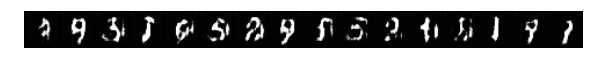

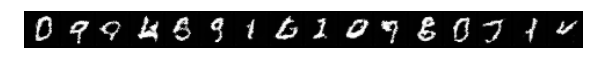

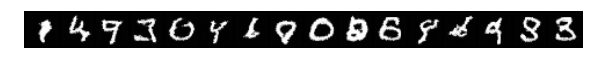

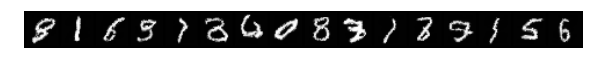

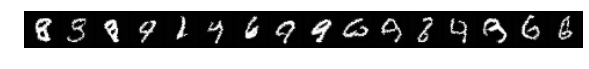

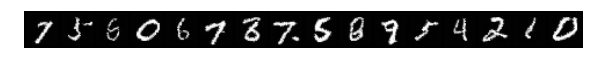

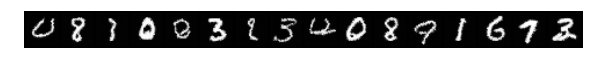

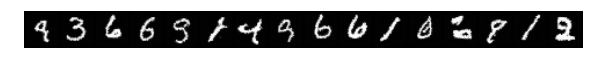

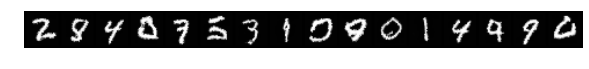

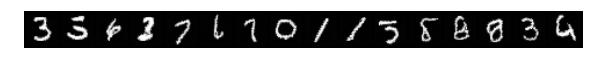

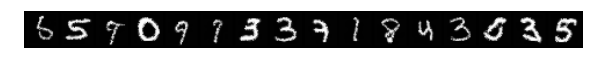

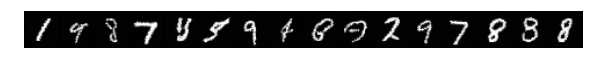

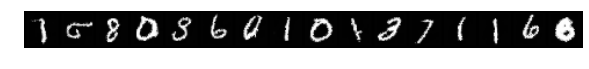

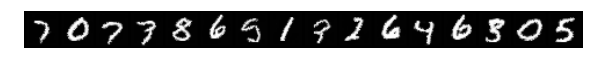

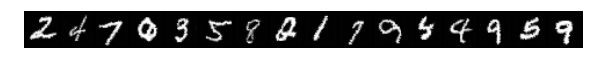

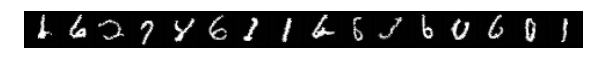

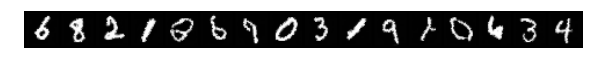

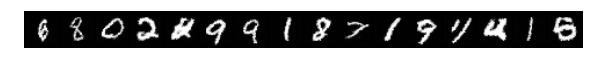

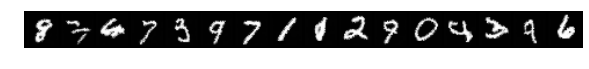

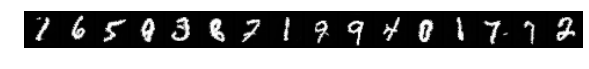

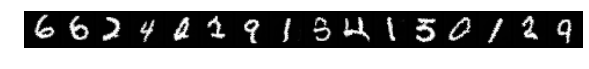

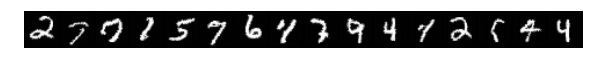

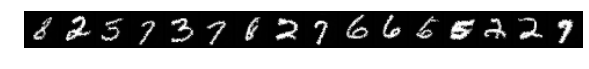

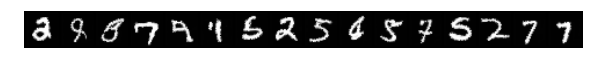

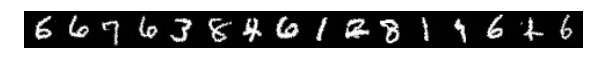

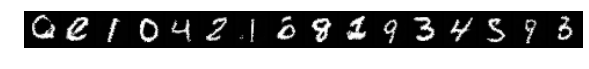

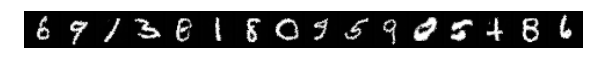

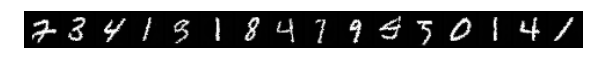

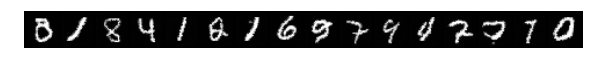

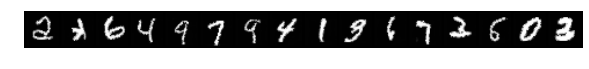

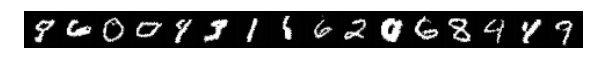

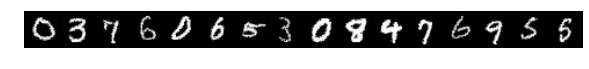

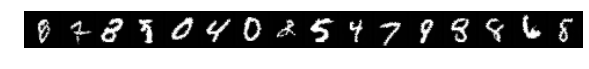

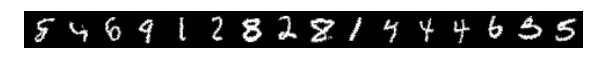

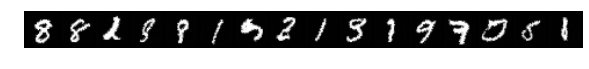

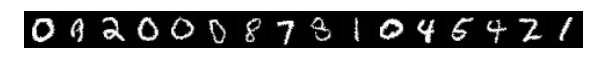

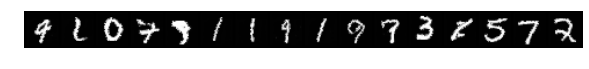

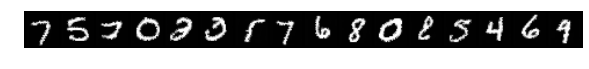

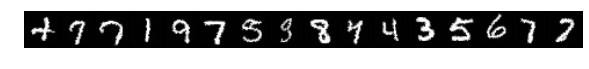

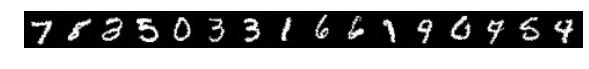

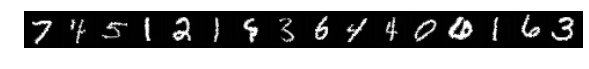

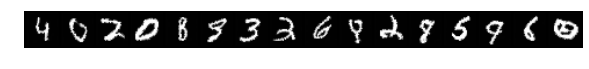

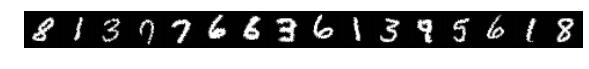

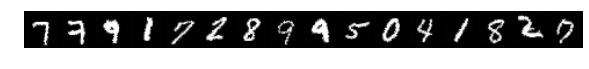

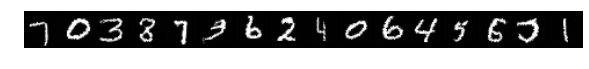

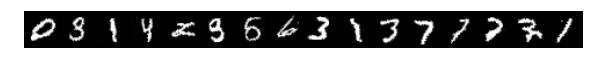

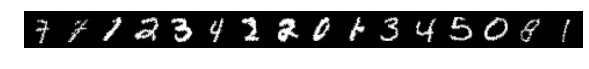

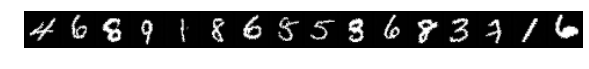

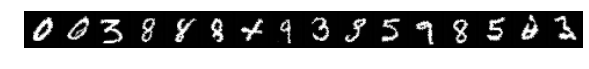

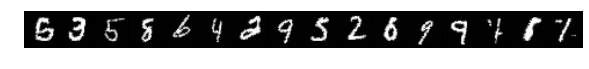

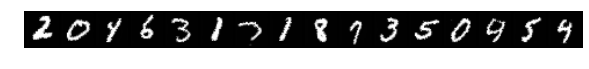

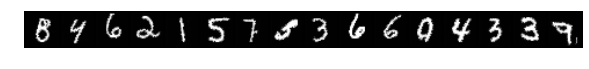

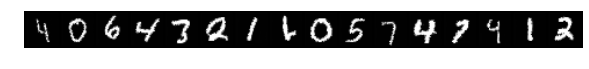

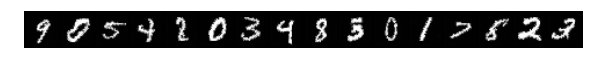

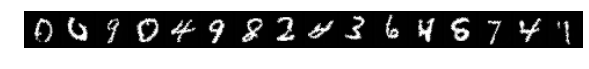

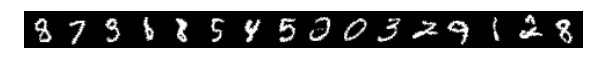

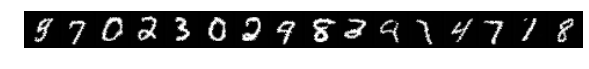

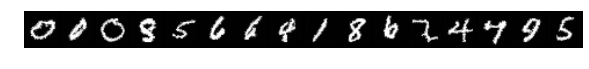

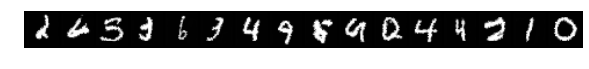

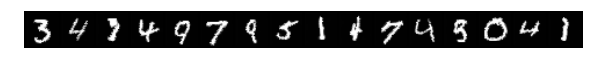

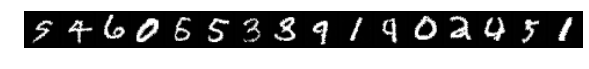

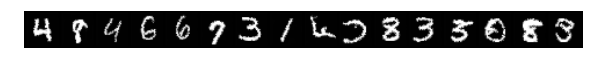

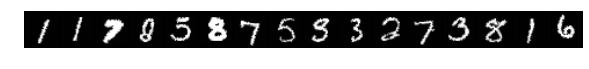

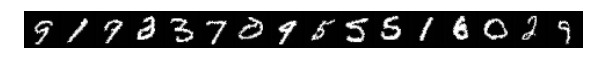

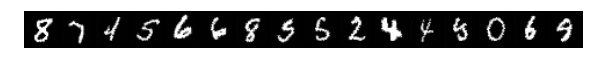

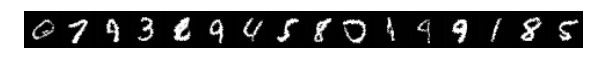

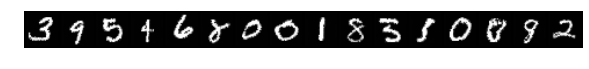

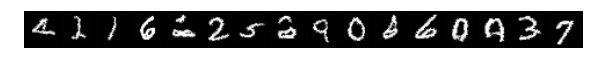

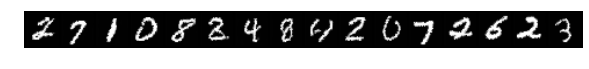

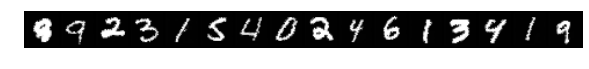

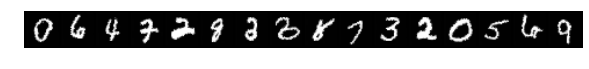

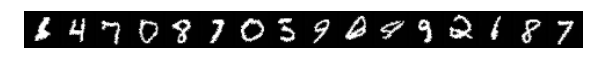

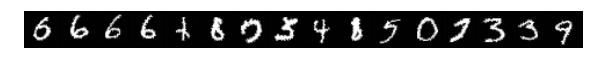

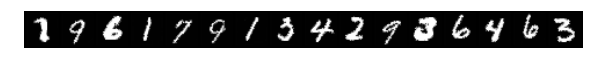

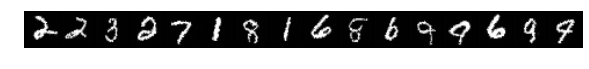

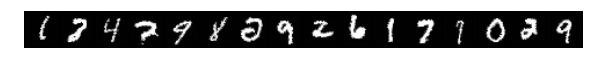

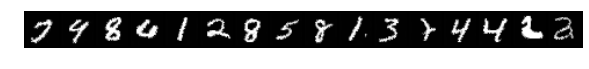

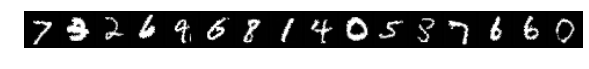

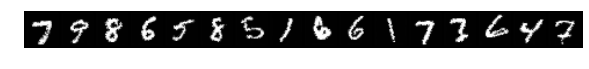

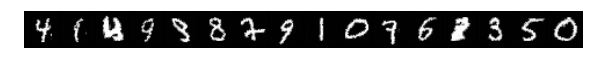

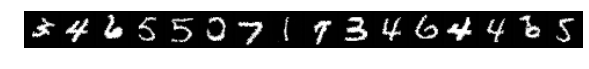

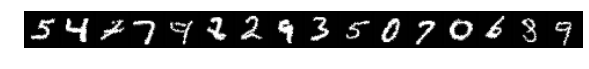

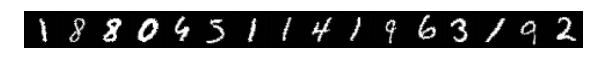

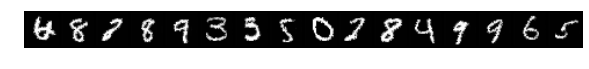

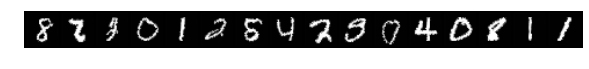

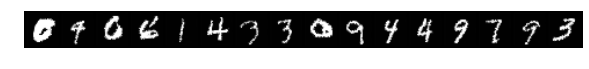

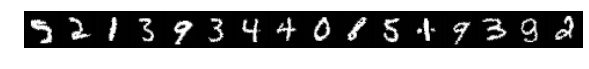

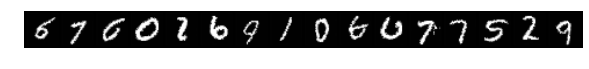

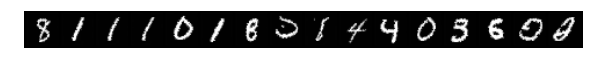

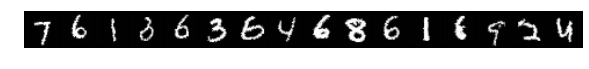

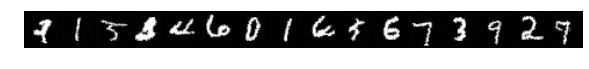

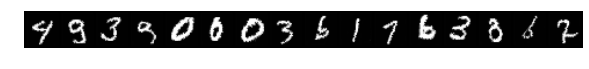

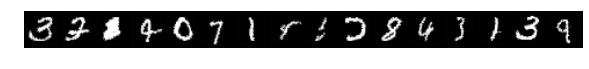

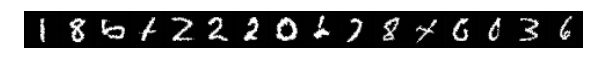

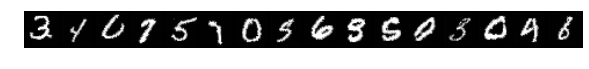

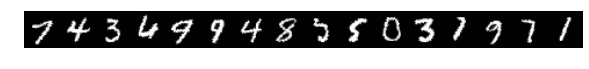

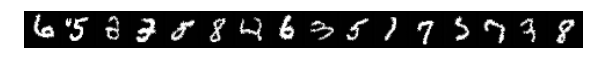

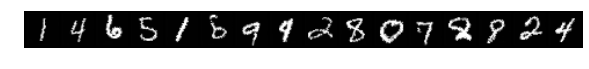

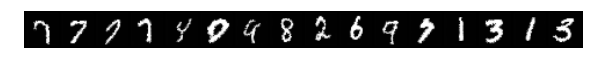

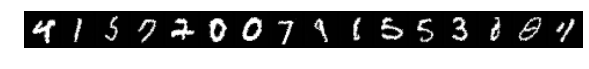

In [9]:
# training
num_epochs = 100
num_samples = 16
num_batches = len(data_loader)

for epoch in range(num_epochs):
    for i, batch in enumerate(data_loader):
        images, _ = batch
        n = images.shape[0]
        images = images.to(device)

        # Train D
        d_optim.zero_grad()

        # Train D on real data
        labels_real = 0.9 * torch.ones((n, 1), device=device)
        d_prediction_real = d(images)
        d_loss_real = criterion(d_prediction_real, labels_real)

        # Train D on fake data
        labels_fake = torch.zeros((n, 1), device=device)
        inputs_fake = torch.randn((n, 32, 1, 1), device=device)
        batch_fake = g(inputs_fake)
        d_prediction_fake = d(batch_fake)
        d_loss_fake = criterion(d_prediction_fake, labels_fake)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()

        d_optim.step()

        # Train G
        g_optim.zero_grad()
        inputs_fake = torch.randn((n, 32, 1, 1), device=device)
        batch_fake = g(inputs_fake)
        d_prediction_fake = d(batch_fake)
        g_loss = criterion(d_prediction_fake, torch.ones((n, 1), device=device))
        g_loss.backward()
        g_optim.step()

        print("Epoch {}: [{:100}]".format(epoch, '#' * int(100 * (i+1) / num_batches)), end='\r')
    
    g.eval()
    os.makedirs('./samples/epoch_{}'.format(epoch), exist_ok=True)

    with torch.no_grad():
        inputs = torch.randn((num_samples, 32, 1, 1), device=device, requires_grad=False)
        outputs = g(inputs).to("cpu")
        
        img = torchvision.utils.make_grid(outputs, nrow=num_samples)
        img = np.transpose(img, (1, 2, 0))
        
        plt.figure(figsize=(10, 5))
        plt.imshow(torchvision.utils.make_grid(img))
        plt.axis('off')
        plt.show()

    g.train()